In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing

In [2]:
mashrooms = pd.read_csv('mushrooms.csv')

In [3]:
mashrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
mushrooms_freq = []
props = mashrooms.drop(columns=['class']).columns

for p in props:
    result = mashrooms[['class', p]].groupby('class').value_counts(normalize=True).reset_index()
    result = result.rename(columns={p: 'p_data', 0: 'p_freq'})
    result['p_name'] = p
    mushrooms_freq.append(result)

mushrooms_freq = pd.concat(mushrooms_freq)

In [5]:
mushrooms_freq.head()

,class,p_data,p_freq,p_name
0,e,x,0.462928,cap-shape
1,e,f,0.379278,cap-shape
2,e,b,0.096008,cap-shape
3,e,k,0.054183,cap-shape
4,e,s,0.007605,cap-shape


In [6]:
def visualizePropsBar(props: list):
    for p in props:
        sns.catplot(x=p, data=mashrooms, hue='class', kind='count')

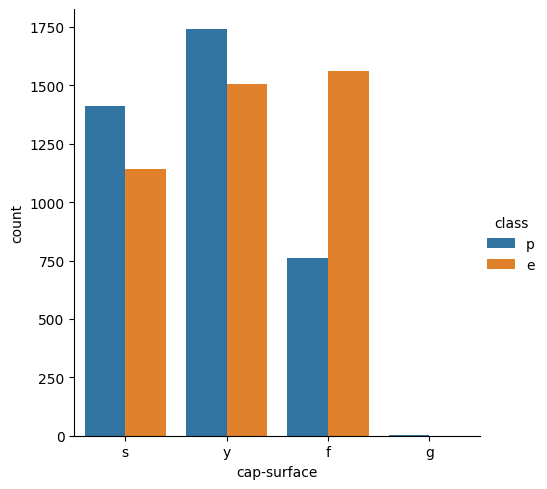

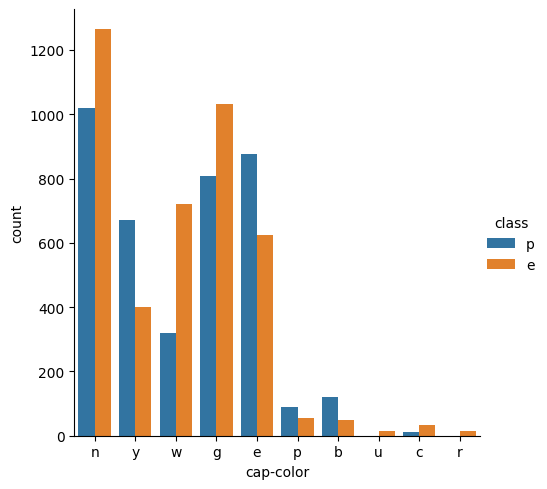

In [7]:
visualizePropsBar(props[1:3])

In [39]:
X = mashrooms[['gill-attachment', 'gill-spacing','gill-size', 'gill-color']]
y = mashrooms['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [9]:
X_test

,gill-attachment,gill-spacing,gill-size,gill-color
5720,f,c,b,w
551,f,w,b,h
2838,f,c,b,u
2750,f,c,b,n
2379,f,c,b,p
...,...,...,...,...
7922,a,c,b,o
6337,f,c,n,b
7363,f,c,n,b
8045,f,c,n,b


In [10]:
class BayesFreq:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.probs = None
    
    def train(self, _lambda=0):
        probs = []
        for c in y.unique():
            prob_class = []
            for feature in X.columns:
                prob_feature = {}
                x = X[feature][y == c]
                k = len(X[feature].unique())
                for i in X[feature].unique():
                    prob_feature[i] = (x[x == i].count() + _lambda) / (x.count() + _lambda * k)
                prob_class.append(prob_feature)
            probs.append(prob_class)
        self.probs = np.array(probs)

        
    def predict(self, X, feature):
        y_pred = []
        idx = X.columns.get_loc(feature)
        prob0_feature = self.probs[0][idx]
        prob1_feature = self.probs[1][idx]
        p0 = y[y == 'e'].count() / y.count()
        p1 = y[y == 'p'].count() / y.count()
        for k in (X[feature]):
            y_pred.append('e' if p0 * prob0_feature[k] < p1 * prob1_feature[k] else 'p')
        return np.array(y_pred)

In [11]:
model = BayesFreq(X_train, y_train)
model.train()

In [12]:
results = {
    'column_name': list(),
    'acc_test': list()
}
for f in X_test.columns:
    results['column_name'].append(f)
    results['acc_test'].append(accuracy_score(y_test, model.predict(X_test,f)))

In [13]:
pd.DataFrame(results)

,column_name,acc_test
0,gill-attachment,0.490862
1,gill-spacing,0.610966
2,gill-size,0.761656
3,gill-color,0.803432


In [14]:
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)

X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.25, random_state=42)

In [15]:
model = sklearn.naive_bayes.CategoricalNB().fit(X_train,y_train)
print('test',accuracy_score(y_test, model.predict(X_test)))
print('train',accuracy_score(y_train, model.predict(X_train)))

test 0.8769079271294928
train 0.8696865255210898


## Bayes from scratch

In [16]:
X = mashrooms[['gill-attachment', 'gill-spacing','gill-size', 'gill-color']]
y = mashrooms['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [22]:
def get_prob_col(column,j, alpha = 0):
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def get_prob(j,alpha = 0): 
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col(col,j,alpha))
    return prob

def predict(X, alpha = 0):
    prob0 = get_prob('e',alpha= alpha)
    prob1 = get_prob('p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]] 
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p') 
        else:
            y_pred.append('e')
    return y_pred

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [35]:
print('train:',accuracy_score(predict(X_train, alpha= 1), y_train))
print('test:',accuracy_score(predict(X_test, alpha= 1), y_test))

train: 0.8754363402535367
test: 0.8634837747109287


In [36]:
# 5

In [37]:
from sklearn.linear_model import LogisticRegression

In [49]:
X = mashrooms.drop(columns=['class'])
y = mashrooms['class']

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.84445265 0.20002515 0.06702046 ... 0.06827024 0.92579481 0.01165559]


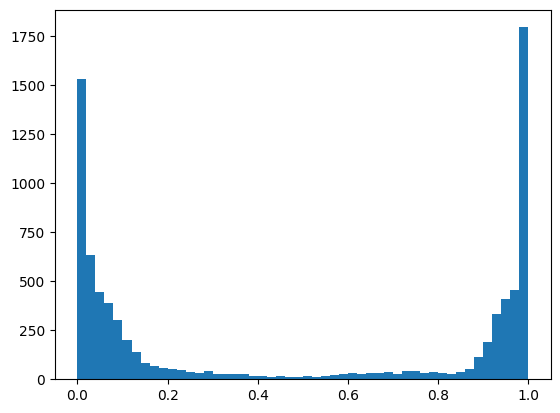

In [50]:
model = LogisticRegression()
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]
print(probs) # просто логистическая регрессия
plt.hist(probs, 50)
plt.show()

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.99985067 0.00502964 0.06678227 ... 0.01288206 0.99999951 0.01775405]


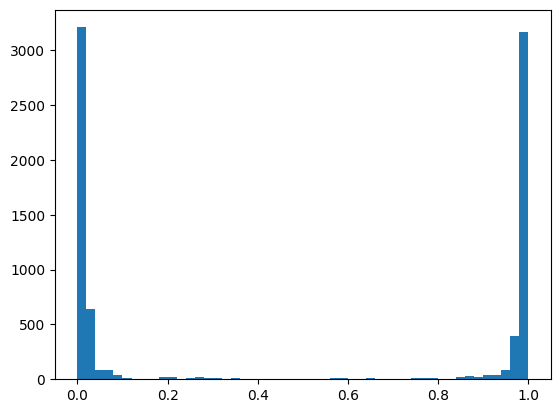

In [52]:
model = LogisticRegression()
X_c = X.copy()
for col in X_c.columns: # для каждой колонки считаем оценки вероятности
    prob = X_c[col].value_counts(normalize=True)
    X_c[col] = X_c[col].apply(lambda x: prob[x])
    X_c[col] = np.log(X_c[col]/(1-X_c[col])) # и делаем обратное логистическое преобразования
    X_c[col] = X_c[col].apply(lambda x: 0 if x == np.inf else x) # при оценке вероятности 1 получается бесконечность, зануляем
y_c = y.copy()
y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]
print(probs) # с обратным логистическим преобразованием
plt.hist(probs, 50)
plt.show()